**Programming Assignment. Clustering**

---

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In that task we will consider the order from the cruise travel agency 'Carnival Cluise Line'. Client wants to promote its services with placing banners across the world. To test the effect from banner placing the client wants to place only 20 banners.

Our aim is to choose the best places for theese banners.

To find the most visited spots we will use the **Forsquare** service.

Free-access data is fetched from the checkins.dat from (https://archive.org/details/201309_foursquare_dataset_umn)

___
# **Preparing the data**

##  **Importing data and converting to pandas DataFrame**

Preprocessing file with the data to csv-like form

In [2]:
with open('../data/umn_foursquare_datasets/checkins.dat') as f:
    data = []
    for line in f:
        # Exclude rows with '--+--'
        if line !='\n' and not re.search(r'\+', line):
            # Split each row by '|'
            line = re.split('\|', line)
            # Remove spaces around the items
            line = list(map(lambda l: l.strip(), line))
            data.append(line)
#the_number_of_symbols_to_limit_the_line_length_is__________________________79

Make the pandas DataFrame

In [3]:
df = pd.DataFrame(data[1:], columns=data[0], index=[s[0] for s in data[1:]])
df = df.drop('id', axis=1)
df.head()

,user_id,venue_id,latitude,longitude,created_at
984301,2041916,5222,,,2012-04-21 17:39:01
984222,15824,5222,38.8951118,-77.0363658,2012-04-21 17:43:47
984315,1764391,5222,,,2012-04-21 17:37:18
984234,44652,5222,33.800745,-84.41052,2012-04-21 17:43:43
984249,2146840,5222,,,2012-04-21 17:42:58


## **Preprocessing the data**

Look at the NaN values

In [4]:
df['latitude'].iloc[0]

''

We will replace these values with np.nan and drop rows containing it form dataset according to the task. These rows are not informative because of the doesn't contain coordinates.

In [383]:
df = df.replace('', np.nan).dropna()
df.head()

,user_id,venue_id,latitude,longitude,created_at
984222,15824,5222,38.895112,-77.036366,2012-04-21 17:43:47
984234,44652,5222,33.800745,-84.410520,2012-04-21 17:43:43
984291,105054,5222,45.523452,-122.676207,2012-04-21 17:39:22
984318,2146539,5222,40.764462,-111.904565,2012-04-21 17:35:46
984232,93870,380645,33.448377,-112.074037,2012-04-21 17:38:18


Fetching to native formats: user_id, venue_id to integers, latitude and longitude to floats.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396634 entries, 984222 to 956733
Data columns (total 5 columns):
user_id       396634 non-null object
venue_id      396634 non-null object
latitude      396634 non-null object
longitude     396634 non-null object
created_at    396634 non-null object
dtypes: object(5)
memory usage: 18.2+ MB


In [8]:
int_cols = ['user_id', 'venue_id']
float_cols = ['latitude', 'longitude']

In [9]:
df[int_cols] = df[int_cols].applymap(int)
df[float_cols] = df[float_cols].applymap(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396634 entries, 984222 to 956733
Data columns (total 5 columns):
user_id       396634 non-null int64
venue_id      396634 non-null int64
latitude      396634 non-null float64
longitude     396634 non-null float64
created_at    396634 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 18.2+ MB


Total size of our dataset is:

In [10]:
df.count()

user_id       396634
venue_id      396634
latitude      396634
longitude     396634
created_at    396634
dtype: int64

___
# **Clustering with the MeanShift**

In [11]:
from sklearn.cluster import MeanShift

## **Fitting the algorithm**

Select the coordinates as data for clustering. Then fit clusterizer on the 100 000 points. Bandwidth threshold 0.1 can be converted in kms as 5-10 km

In [16]:
X = np.array(df[float_cols])

In [31]:
%%time
mean_shift_clr = MeanShift(bandwidth=0.1)
preds = mean_shift_clr.fit_predict(X[:100_000])

CPU times: user 1min 50s, sys: 888 ms, total: 1min 51s
Wall time: 1min 52s


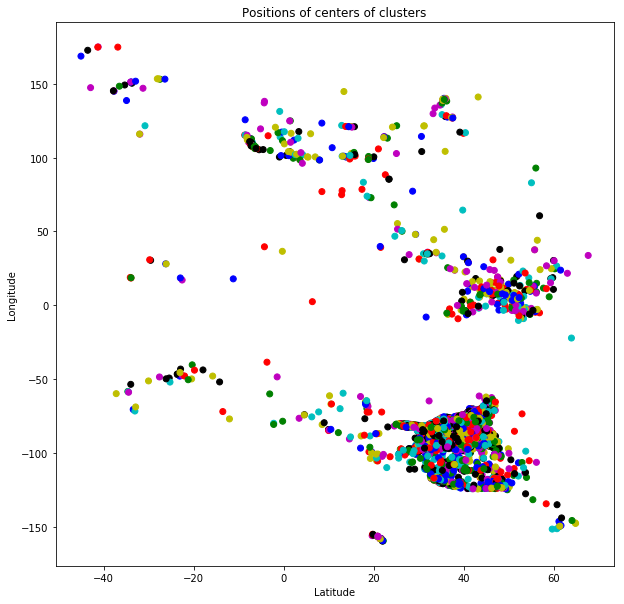

In [376]:
plt.figure(figsize=(10,10))
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

centers = mean_shift_clr.cluster_centers_
center_colors = colors[:len(centers)]

plt.scatter(centers[:, 0], centers[:, 1], c=center_colors)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Positions of centers of clusters');

## **Processing results**

### Finding the optimal clusters

Select clusters with more that 15 entries

In [72]:
from collections import Counter

count = Counter(preds)
count_arr = np.array(count.most_common())
most_clusters = count_arr[count_arr[:,1]>15]

In [77]:
most_clusters[:3]

array([[    0, 12471],
       [    1,  4692],
       [    2,  3994]])

Get optimal cluster centers with more than 15 entries incorporated. It means, that we choose adequately visited places for further processing

In [401]:
optimal_centers = []
for i in most_clusters[:,0]:
    # Note that clr.cluster_centers_ returns centers of clr with 
    # index equals number of cluster.  So cluster_centers_[0] 
    # belongs to the cluster 0. 
    optimal_centers.append(list(mean_shift_clr.cluster_centers_[i]))

optimal_centers = np.array(optimal_centers)
optimal_centers[:5]

array([[  40.7177164 ,  -73.99183542],
       [  33.44943805, -112.00213969],
       [  33.44638027, -111.90188756],
       [  37.68868157, -122.40933037],
       [  41.87824378,  -87.62984336]])

Writing data to vizualise on the map with https://mapcustomizer.com

In [112]:
with open('../data/optimal_centers.txt', 'w') as fout:
    for line in optimal_centers:
        fout.write(str(line[0]) +','+ str(line[1]) + '\n')

### Selecting the cluster point nearest to any office

We need to put several banners near the company offices (like in the same districs or quarters). As we concluded, optimal cluster centers are the best points to place the banners, we will choose the 20 nearest clusters to offices and propose they to client.

File processing
___

In [377]:
with open('../data/umn_foursquare_datasets/offices.txt') as f:
    offices = []
    for line in f:
        if line != '\n': 
            offices.append(line.strip('\n'))
offices

['33.751277, -118.188740 (Los Angeles)',
 '25.867736, -80.324116 (Miami)',
 '51.503016, -0.075479 (London)',
 '52.378894, 4.885084 (Amsterdam)',
 '39.366487, 117.036146 (Beijing)',
 '-33.868457, 151.205134 (Sydney)']

Parsing resulted file. We will make office coords dictionary with key as city to simplify the processing in the future

In [299]:
off_coords = []
for line in offices:
    line = line.split(', ')
    line.append(line[1].split(' (')[1].strip(')'))
    line[1] = line[1].split(' (')[0].strip()
    off_coords.append(line)

office_coords = np.array(off_coords)

office_coords = {
    line[2]: np.array(line)[:2].astype(float) for line in off_coords
}

Estimating the distances and printing results.

In [382]:
dist = []
for office, coords in office_coords.items():
    for point in optimal_centers:
        distance = np.linalg.norm(coords - point)
        dist.append((distance, point, office))

# The number of optimal centers from sorted dist set can be choosen.
for dist, point, city in sorted(dist)[:10]:
    print(f'Distance: {dist:.4f}\
    Point coords: {point[0]:.4f} {point[1]:.4f}\
\tCity: {city}')

Distance: 0.0078    Point coords: -33.8606 151.2048	City: Sydney
Distance: 0.0094    Point coords: 52.3730 4.8923	City: Amsterdam
Distance: 0.0227    Point coords: 25.8457 -80.3189	City: Miami
Distance: 0.0501    Point coords: 51.5030 -0.1255	City: London
Distance: 0.0708    Point coords: 33.8099 -118.1489	City: Los Angeles
Distance: 0.1341    Point coords: 25.7858 -80.2179	City: Miami
Distance: 0.1674    Point coords: 25.7053 -80.2834	City: Miami
Distance: 0.1889    Point coords: 26.0101 -80.2000	City: Miami
Distance: 0.1958    Point coords: 33.8883 -118.0489	City: Los Angeles
Distance: 0.2118    Point coords: 33.8730 -118.3621	City: Los Angeles
